# Introduction

In this tutorial, we demonstrate how to use Monocle 2 to resolve the complicated haematopoiesis process that contains five branch points from the Paul dataset by applying reversed graph embedding (RGE). The reconstructed developmental trajectory is learned in ten dimensions, selected based on PC variance explained, but can be visualized in two dimensions using a tree layout. We show that the structure of the tree we reconstructed match well with the cell type assignment from the original paper. When we use genes based on the Paul dataset to define stemness or lineage specificity for each cell on the tree, we can see the smooth transition of cell differentation. Multi-way kinetic curves / heatmap visualizes the dynamics of six different cell fate commitment.

This notebook reproduces figures shown in Supplementary Figure 16 of the Monocle 2 paper. 

# Load the necessary package and data
Make sure you install Monocle 2 and other packages correctly in your environment first

In [1]:
rm(list = ls()) # clear the environment 
#load all the necessary libraries 
options(warn=-1) # turn off warning message globally 
suppressMessages(library(monocle))
suppressMessages(library(plyr))
suppressMessages(library(dplyr))

# Load the RData
In order to match our analysis with other groups's analysis, in particular those by DPT method from Thesis group, we used the RData from Maren Büttner

In [2]:
# this RData is from Maren Büttner (https://github.com/theislab/scAnalysisTutorial)
load('./Paul_Cell_MARSseq_GSE72857.RData') 
# the following code is used to select feature genes used by Maren 
gene.names <-sapply(strsplit(rownames(data.debatched), ";"), "[", 1)
is.informative <- gene.names %in% info.genes[order(info.genes)]
data.info.genes <- data.debatched[is.informative,]
rownames(data.info.genes) <- gene.names[is.informative]

# Create the cds from stratch 
1. we downloaded the GSE72857_umitab.txt.gz / GSE72857_experimental_design.txt.gz file from GEO website 
2. we obtained MAP.csv from Ido Amit group through email 
3. we intersect the gene names from the GSE72857_umitab file and those from the info.genes created by Maren Büttner to define the informative genes. 
4. we used the expression matrix from her to create the cds (Steps 3 & 4 are used for the purpose of consistency with DPT)

In [3]:
################################################################################################################################################
# obtain this mat file from Ido Amit group  
MAP_cells_clusters <- read.csv('/Users/xqiu/Downloads/MAP.csv', header = F)
row.names(MAP_cells_clusters) <- MAP_cells_clusters$V1

#filtering cells to include only the ones which were assigned a cluster id: 
valid_subset_GSE72857_exprs <- read.table('/Users/xqiu/Downloads/GSE72857_umitab.txt', header = T, row.names = 1)
design_mat <- read.table('/Users/xqiu/Dropbox (Personal)/Projects/DDRTree_fstree/DDRTree_fstree/csv_data/GSE72857_experimental_design.txt', header = T, row.names = 1, skip = 19, sep = '\t')
design_mat$cluster <- MAP_cells_clusters[row.names(design_mat), 'V2']
valid_design_mat <- subset(design_mat, !is.na(cluster))

# Get the intersect gene used by Maren Büttner and the genes we have 
common_genes <- rownames(valid_subset_GSE72857_exprs)[rownames(valid_subset_GSE72857_exprs) %in% info.genes]
fd <- new("AnnotatedDataFrame", data = data.frame(gene_short_name = common_genes, row.names = common_genes))
pd <- new("AnnotatedDataFrame", data = valid_design_mat)

# create a CDS with data.info.genes 
valid_subset_GSE72857_cds <- newCellDataSet(as(as.matrix(data.info.genes[common_genes, ]), 'sparseMatrix'), 
                                            phenoData = pd, 
                                            featureData = fd,
                                            lowerDetectionLimit=1,
                                            expressionFamily=negbinomial.size())
valid_subset_GSE72857_cds <- estimateSizeFactors(valid_subset_GSE72857_cds)
valid_subset_GSE72857_cds <- estimateDispersions(valid_subset_GSE72857_cds)

pData(valid_subset_GSE72857_cds)$cell_type <- revalue(as.character(pData(valid_subset_GSE72857_cds)$cluster), 
                                                      c("1" = 'erythroid', "2" = 'erythroid', "3" = 'erythroid', "4" = 'erythroid', "5" = 'erythroid', "6" = 'erythroid', 
                                                        "7" = 'CMP', "8" = 'CMP', "9" = 'CMP', "10" = 'CMP',
                                                        "11" = 'DC', 
                                                        "12" = 'GMP', "13" = 'GMP', "14" = 'GMP', "15" = 'GMP', "16" = 'GMP', "17" = 'GMP', "18" = 'GMP', 
                                                        "19" = 'lymphoid'))

#remove all lymphoid cells as it is not belong to myeloid lineage 
valid_subset_GSE72857_cds <- valid_subset_GSE72857_cds[, pData(valid_subset_GSE72857_cds)$cell_type != 'lymphoid']

Removing 23 outliers


# Reconstruct the trajectory with Monocle 2 
1. Select the dimension of the intrinsic space of the Paul dataset based on PC variance explained
2. Run Monocle 2 by default to reconstruct the principal graph in 10 dimensions. norm_method is set to log. 

Warning message in (function (A, nv = 5, nu = nv, maxit = 100, work = nv + 7, reorth = TRUE, :
“did not converge--results might be invlaid!; try increasing maxit or fastpath=FALSE”

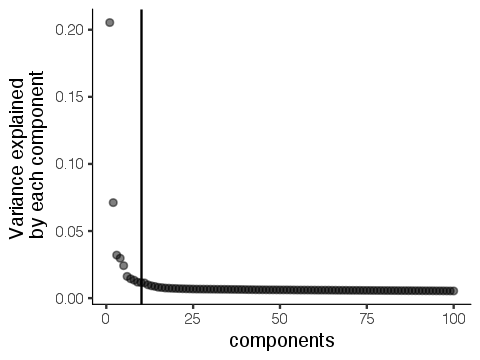

In [4]:
options(repr.plot.width=4, repr.plot.height=3)
plot_pc_variance_explained(valid_subset_GSE72857_cds) + geom_vline(xintercept = 10)
valid_subset_GSE72857_cds2 <- reduceDimension(valid_subset_GSE72857_cds, norm_method = 'log', verbose = F, max_components = 10) 
valid_subset_GSE72857_cds2 <- orderCells(valid_subset_GSE72857_cds2, reverse = T)


# Make the multiple branch plot 
Now we can set the root state for the tree layout as state 10, and 
1. show that we can reproduce Figure 16A 
2. show that we can reproduce Figure 16B

The following `from` values were not present in `x`: 19


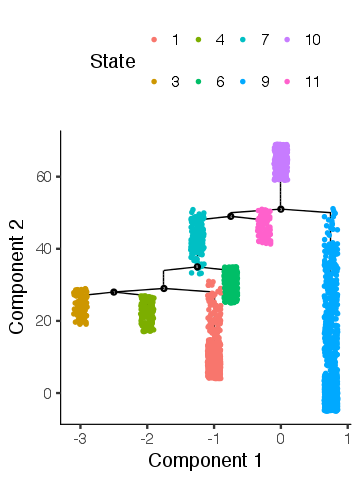

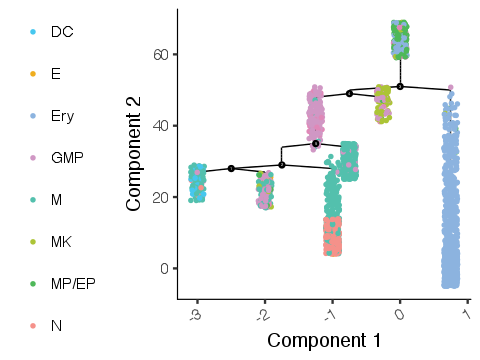

In [5]:
detailed_cell_type_color <- c("B" = "#E088B8", "DC" = "#46C7EF", "E" = "#EFAD1E", "Ery" = "#8CB3DF", "M" = "#53C0AD", "MP/EP" = "#4EB859", "GMP" = "#D097C4", "MK" = "#ACC436", "N" = "#F5918A")

pData(valid_subset_GSE72857_cds2)$cell_type2 <- revalue(as.character(pData(valid_subset_GSE72857_cds2)$cluster), 
                                                        c("1" = 'Ery', "2" = 'Ery', "3" = 'Ery', "4" = 'Ery', "5" = 'Ery', "6" = 'Ery', 
                                                          "7" = 'MP/EP', "8" = 'MK', "9" = 'GMP', "10" = 'GMP',
                                                          "11" = 'DC', 
                                                          "12" = 'B', "13" = 'B', "14" = 'M', "15" = 'M', "16" = 'N', "17" = 'N', "18" = 'E', 
                                                          "19" = 'lymphoid'))

# we find a typo where the number labels of states 4 and 1 are swapped in the figure 16A, we will correct this. 
options(repr.plot.width=3, repr.plot.height=4)
plot_complex_cell_trajectory(valid_subset_GSE72857_cds2, color_by = 'State', show_branch_points = T, 
                             cell_size = 0.5, cell_link_size = 0.3, root_states = c(10))  

options(repr.plot.width=4, repr.plot.height=3)
plot_complex_cell_trajectory(valid_subset_GSE72857_cds2, color_by = 'as.factor(cell_type2)', show_branch_points = T, 
                             cell_size = 0.5, cell_link_size = 0.3, root_states = c(10)) + scale_size(range = c(0.2, 0.2)) +
  theme(axis.text.x = element_text(angle = 30, hjust = 1)) +
  theme (legend.position="left", legend.title=element_blank()) + scale_color_manual(values = detailed_cell_type_color) 

# Reproduce Figure 16c
1. Calculate the distribution of each state into the cell type classification from the original study

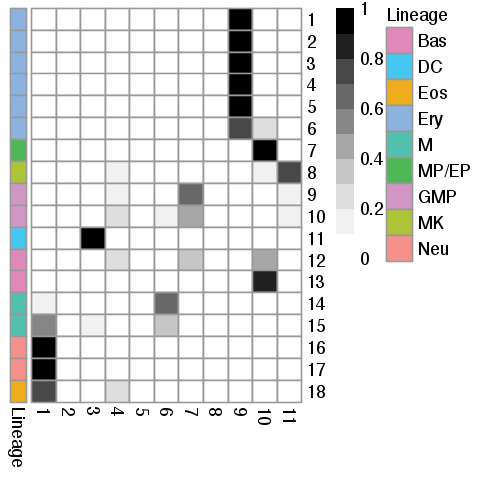

In [6]:
annotation_row = data.frame(`Lineage` = c("1" = 'Ery', "2" = 'Ery', "3" = 'Ery', "4" = 'Ery', "5" = 'Ery', "6" = 'Ery', 
                                          "7" = 'MP/EP', "8" = 'MK', "9" = 'GMP', "10" = 'GMP',
                                          "11" = 'DC', 
                                          "12" = 'Bas', "13" = 'Bas', "14" = 'M', "15" = 'M', "16" = 'Neu', "17" = 'Neu', "18" = 'Eos', 
                                          "19" = 'lymphoid')) 
state_cluster_stat <- table(pData(valid_subset_GSE72857_cds2)[, c('State', 'cluster')])

state_cluster_stat <- apply(state_cluster_stat, 2, function(x) x / sum(x))
state_cluster_stat_ordered <- t(state_cluster_stat)
detailed_cell_type_color <- c("Bas" = "#E088B8", "DC" = "#46C7EF", "Eos" = "#EFAD1E", "Ery" = "#8CB3DF", "M" = "#53C0AD", "MP/EP" = "#4EB859", "GMP" = "#D097C4", "MK" = "#ACC436", "Neu" = "#F5918A")
annotation_colors = list(`Lineage` = detailed_cell_type_color)
options(repr.plot.width=4, repr.plot.height=4)
pheatmap::pheatmap(state_cluster_stat_ordered, cluster_cols = F, cluster_rows = F, color = colorRampPalette(RColorBrewer::brewer.pal(n=9, name='Greys'))(10), 
                   annotation_row = annotation_row, annotation_colors = annotation_colors)

# Make the cell type identity more clear 
The color legend for cell types above is a nice representation but kind hard to distinguish for those who doesn't have gifted eyes. We explicitly label the names for the cell types below and this helps annotating the cell types in Reproduce Figure 16A

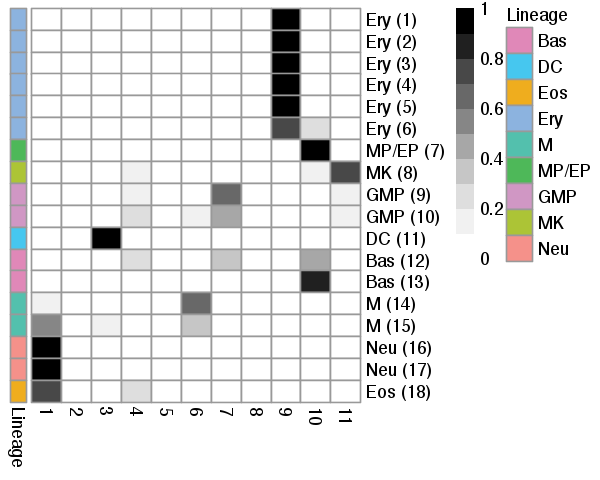

In [7]:
annotation_row = data.frame(`Lineage` = c("Ery (1)" = 'Ery', "Ery (2)" = 'Ery', "Ery (3)" = 'Ery', "Ery (4)" = 'Ery', "Ery (5)" = 'Ery', "Ery (6)" = 'Ery', 
                                          "MP/EP (7)" = 'MP/EP', "MK (8)" = 'MK', "GMP (9)" = 'GMP', "GMP (10)" = 'GMP',
                                          "DC (11)" = 'DC', 
                                          "Bas (12)" = 'Bas', "Bas (13)" = 'Bas', "M (14)" = 'M', "M (15)" = 'M', "Neu (16)" = 'Neu', "Neu (17)" = 'Neu', "Eos (18)" = 'Eos', 
                                          "lymphoid (19)" = 'lymphoid')) 
state_cluster_stat <- table(pData(valid_subset_GSE72857_cds2)[, c('State', 'cluster')])

state_cluster_stat <- apply(state_cluster_stat, 2, function(x) x / sum(x))
colnames(state_cluster_stat) <- row.names(annotation_row)[1:18]

state_cluster_stat_ordered <- t(state_cluster_stat)
detailed_cell_type_color <- c("Bas" = "#E088B8", "DC" = "#46C7EF", "Eos" = "#EFAD1E", "Ery" = "#8CB3DF", "M" = "#53C0AD", "MP/EP" = "#4EB859", "GMP" = "#D097C4", "MK" = "#ACC436", "Neu" = "#F5918A")
annotation_colors = list(`Lineage` = detailed_cell_type_color)

options(repr.plot.width=5, repr.plot.height=4)
pheatmap::pheatmap(state_cluster_stat_ordered, cluster_cols = F, cluster_rows = F, color = colorRampPalette(RColorBrewer::brewer.pal(n=9, name='Greys'))(10), 
                   annotation_row = annotation_row, annotation_colors = annotation_colors)

# Show the stemness and lineage score 
In the following, we first load the genes (based on an orthogonal Olsson dataset) to define stemness or lineage score. 
- The lineage score is calculated as the average erythroid gene expression - the average GMP gene expression 
- The stemness score is calculated as the average expression of those stemness genes 
- Visualize the stemness / lineage score on the complex tree structure 

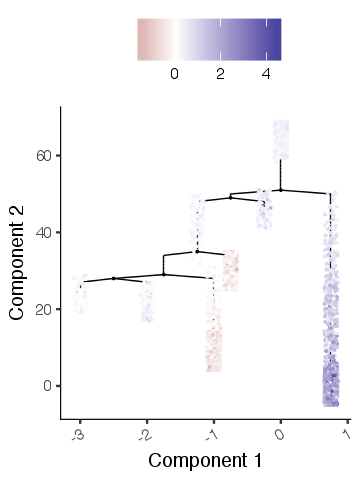

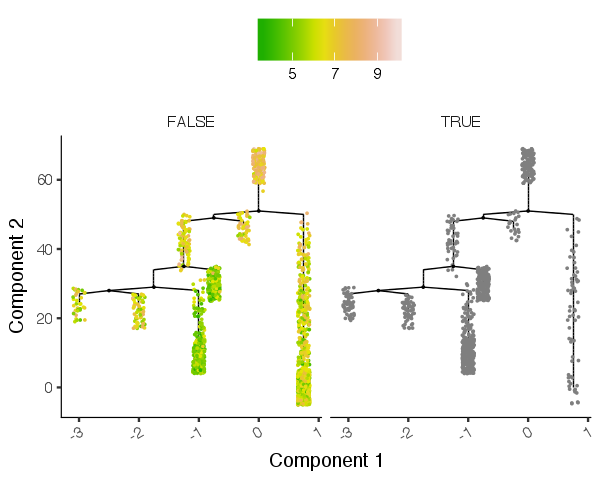

In [8]:
# load in the genes used to define stemness and genes used to define lineage score: 
load('gene_set') #including three variables: all_down_valid, positive_score_genes, negtive_score_genes 

cell_ery_meg_lineage_score <- esApply(valid_subset_GSE72857_cds2[c(positive_score_genes, negtive_score_genes), ], 2, function(x) mean(x[1:length(positive_score_genes)]) - mean(x[length(positive_score_genes):length(x)]))

pData(valid_subset_GSE72857_cds2)$ery_meg_lineage_score <- -cell_ery_meg_lineage_score

options(repr.plot.width=3, repr.plot.height=4)
plot_complex_cell_trajectory(valid_subset_GSE72857_cds2, color_by = 'ery_meg_lineage_score', show_branch_points = T, cell_link_size = 0.3, cell_size = 0.0001, root_states = 10) +
  scale_colour_gradient2() + scale_size(range = c(0.2, 0.2)) +
   theme(axis.text.x = element_text(angle = 30, hjust = 1)) + theme (legend.position="right", legend.title=element_blank()) +
  theme(legend.position="top", legend.title=element_blank()) 

#normalize UMI to TPM:
tpm_exprs_valid_subset_GSE72857_cds2 <- esApply(valid_subset_GSE72857_cds2, 2, function(x) x / sum(x) * 1e6)
cell_stemness_score <- apply(tpm_exprs_valid_subset_GSE72857_cds2[all_down_valid, ], 2, function(x) mean(x))
# cell_stemness_score <- esApply(valid_subset_GSE72857_cds2[all_down_valid, ], 2, function(x) mean(x))

pData(valid_subset_GSE72857_cds2)$cell_stemness_score <- log2(cell_stemness_score)
pData(valid_subset_GSE72857_cds2)$no_expression <- cell_stemness_score == 0
    
options(repr.plot.width=5, repr.plot.height=4)
plot_complex_cell_trajectory(valid_subset_GSE72857_cds2, color_by = 'cell_stemness_score', show_branch_points = T, cell_link_size = 0.3, cell_size = 0.0001, root_states = 10) +
  scale_colour_gradientn(colours = terrain.colors(10)) + facet_wrap(~no_expression) + scale_size(range = c(0.2, 0.2)) +
  theme(axis.text.x = element_text(angle = 30, hjust = 1)) + theme (legend.position="right", legend.title=element_blank()) +
  theme(legend.position="top", legend.title=element_blank()) 


# Create the multi-way kinetic curves 
- we visualize a few marker genes' expression over the six different fate commitments

[1] 450

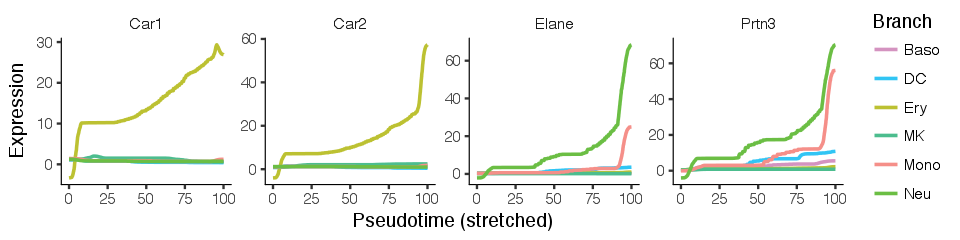

In [9]:
# ensure pseudotime starts from cell state 10 

which(pData(valid_subset_GSE72857_cds2)$Pseudotime == 0) # this should be 449
marseq_complex_tree_ery_meg_lineage_score_kinetic_curves_cols <- c("Neu" = "#6BBE44", "DC" = "#31C5F4", "Baso" = "#D493C0", "Mono" = "#F58F89", "MK" = "#4CBD8E", "Ery" = "#BCC132")

valid_subset_GSE72857_cds2 <- orderCells(valid_subset_GSE72857_cds2, root_state = 10) 

options(repr.plot.width=8, repr.plot.height=2)
plot_multiple_branches_pseudotime(valid_subset_GSE72857_cds2[c('Car1', 'Elane', 'Car2', 'Prtn3'),],
                                  branches=c(1, 3, 4, 6, 11, 9),
                                  branches_name=c("Neu", "DC", "Baso", "Mono", "MK", "Ery"), color_by = 'Branch',
                                  nrow = 1, ncol = 4) + scale_color_manual(values = marseq_complex_tree_ery_meg_lineage_score_kinetic_curves_cols)


# Create the multi-way branched heatmap 
- we can also visualize all the genes used to define the lineage score in a multi-way heatmap

<simpleError in checkwz(wz, M = M, trace = trace, wzepsilon = control$wzepsilon): NAs found in the working weights variable 'wz'>
<simpleError in checkwz(wz, M = M, trace = trace, wzepsilon = control$wzepsilon): NAs found in the working weights variable 'wz'>


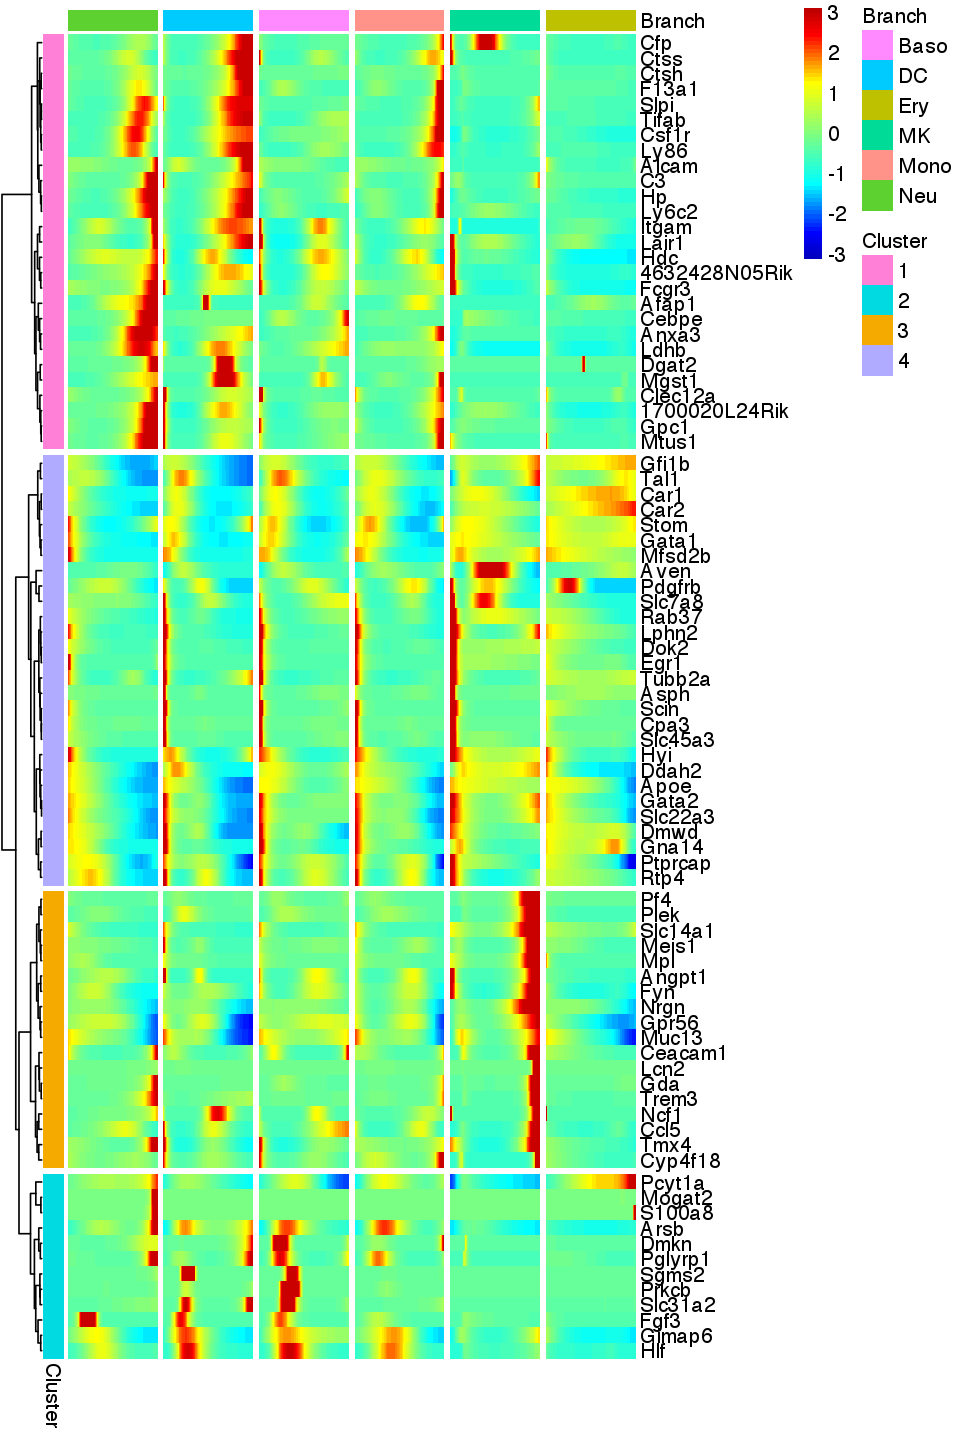

In [10]:
options(repr.plot.width=8, repr.plot.height=12)
plot_multiple_branches_heatmap(valid_subset_GSE72857_cds2[c(positive_score_genes, negtive_score_genes),],
                               branches=c(1, 3, 4, 6, 11, 9),
                               branches_name=c("Neu", "DC", "Baso", "Mono", "MK", "Ery"),
                               show_rownames=T,
                               num_clusters=4)

# Show the session info 

In [11]:
sessionInfo()

R version 3.3.2 (2016-10-31)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: OS X Yosemite 10.10.5

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
 [1] splines   stats4    parallel  stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] dplyr_0.5.0         plyr_1.8.4          monocle_2.5.3      
 [4] DDRTree_0.1.5       irlba_2.2.1         VGAM_1.0-3         
 [7] ggplot2_2.2.1       Biobase_2.34.0      BiocGenerics_0.20.0
[10] Matrix_1.2-10      

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.11           RColorBrewer_1.1-2     tools_3.3.2           
 [4] densityClust_0.2.1     digest_0.6.12          uuid_0.1-2            
 [7] jsonlite_1.4           evaluate_0.10          Rtsne_0.13            
[10] tibble_1.3.1           gtable_0.2.0           lattice_0.20-35       
[13] rlang_0.1.1            igraph_1.0.1           IRdisplay_0.4.4       
[16] DBI_0.6-1     